In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier, plot_importance

import utils.datasets_utils as datasets_utils
import utils.classification_utils as classification_utils

sns.set_palette("Set2")
sns.set_style("whitegrid")

In [2]:
datasets = datasets_utils.load_datasets()
datasets_wrapper = datasets_utils.DatasetsWrapper(datasets)

In [3]:
datasets_wrapper.get_shapes()

,train_X,val_X,test_X,train_y,val_y,test_y
spectral_original,"(21572, 196)","(2397, 196)","(5993, 196)","(21572,)","(2397,)","(5993,)"
all_original,"(21572, 294)","(2397, 294)","(5993, 294)","(21572,)","(2397,)","(5993,)"
pca_original,"(21572, 141)","(2397, 141)","(5993, 141)","(21572,)","(2397,)","(5993,)"
umap_original,"(21572, 15)","(2397, 15)","(5993, 15)","(21572,)","(2397,)","(5993,)"
spectral_modified,"(20714, 196)","(2397, 196)","(5993, 196)","(20714,)","(2397,)","(5993,)"
all_modified,"(20714, 294)","(2397, 294)","(5993, 294)","(20714,)","(2397,)","(5993,)"
pca_modified,"(20714, 140)","(2397, 140)","(5993, 140)","(20714,)","(2397,)","(5993,)"
umap_modified,"(20714, 15)","(2397, 15)","(5993, 15)","(20714,)","(2397,)","(5993,)"


# 1. Random Forest

## 1.1. Training

Initially we will create a model with the following hyperparemeters in order to decide with which dataset to continue the analysis (what subset of feature more preciesly).
Note that scaling the data is not neccesary when using tree-based methods, since they "look at" the features in isloation, performing axis-aligned splits.

In [4]:
rf_classifiers = [classification_utils.ClassifierFactory.create_instance(
    dataset=dataset, 
    classifier=RandomForestClassifier(criterion='gini', max_depth=50, min_samples_split=20, n_estimators=100, random_state=42, n_jobs=5),
    tree_type_classifier=True
) for dataset in datasets]

In [5]:
rf_cl_collection = classification_utils.ClassifiersCollection(rf_classifiers)

In [6]:
rf_cl_collection.fit_classifiers()

Fitting classifiers...


100%|██████████| 8/8 [02:22<00:00, 17.77s/it]

Done


## 1.2. Initial Results

In [7]:
rf_evaluation_df = rf_cl_collection.evaluate_classifiers()

In [8]:
rf_evaluation_df[[dataset.name for dataset in datasets if 'original' in dataset.name]]

spectral_original                     all_original  \
                                 train       val      test        train   
accuracy                      0.880308  0.598248  0.602703     0.887771   
precision (weighted)          0.891015  0.561815  0.599470     0.897734   
recall (weighted)             0.880308  0.598248  0.602703     0.887771   
f1 (weighted)                 0.866293  0.553745  0.559745     0.874043   

                                         pca_original                      \
                           val      test        train       val      test   
accuracy              0.605340  0.603037     0.883692  0.568210  0.558652   
precision (weighted)  0.569840  0.603533     0.893299  0.549504  0.565835   
recall (weighted)     0.605340  0.603037     0.883692  0.568210  0.558652   
f1 (weighted)         0.561798  0.560977     0.866498  0.505954  0.496419   

                     umap_original                      
                             train       val      test  
accuracy                  0.731550  0.546099  0.551977  
precision (weighted)      0.742983  0.511687  0.524841  
recall (weighted)         0.731550  0.546099  0.551977  
f1 (weighted)             0.712192  0.517459  0.525108

In [9]:
rf_evaluation_df[[dataset.name for dataset in datasets if 'modified' in dataset.name]]

spectral_modified                     all_modified  \
                                 train       val      test        train   
accuracy                      0.932123  0.601168  0.603204     0.939365   
precision (weighted)          0.934170  0.589404  0.607968     0.941009   
recall (weighted)             0.932123  0.601168  0.603204     0.939365   
f1 (weighted)                 0.930834  0.586392  0.592730     0.938086   

                                         pca_modified                      \
                           val      test        train       val      test   
accuracy              0.604923  0.603871     0.953075  0.574468  0.572501   
precision (weighted)  0.596973  0.608233     0.954714  0.561259  0.573411   
recall (weighted)     0.604923  0.603871     0.953075  0.574468  0.572501   
f1 (weighted)         0.589618  0.592623     0.951355  0.549504  0.547521   

                     umap_modified                      
                             train       val      test  
accuracy                  0.747465  0.518982  0.517771  
precision (weighted)      0.753820  0.546093  0.540749  
recall (weighted)         0.747465  0.518982  0.517771  
f1 (weighted)             0.744931  0.522906  0.518821

all_modified seems to have the best results on validation set, therefore we will use this dataset for further fine-tuning

In [10]:
rf_all_modified_classifier = rf_cl_collection.get_classifier('all_modified')

In [11]:
rf_all_modified_classifier.get_clf_evaluation().get_scores()

,train,val,test
accuracy,0.939365,0.604923,0.603871
precision (weighted),0.941009,0.596973,0.608233
recall (weighted),0.939365,0.604923,0.603871
f1 (weighted),0.938086,0.589618,0.592623


## 1.3 Hyperparameter tuning

In [12]:
rf_dataset = datasets_wrapper.get_dataset('all_modified')

rf_train_X, rf_train_y = rf_dataset.train.X, rf_dataset.train.y
rf_val_X, rf_val_y = rf_dataset.val.X, rf_dataset.val.y

We will use grid search with the following hyperparameter combinations

In [13]:
params = dict(n_estimators=[50, 100, 150], max_depth=[15, 25, 30], min_samples_split=[20, 40, 60])

In [14]:
rf_clf = RandomForestClassifier(criterion='gini', random_state=42, n_jobs=5)
skf = StratifiedKFold(5, shuffle=True, random_state=23)
grid_search = GridSearchCV(rf_clf, params, cv=3, n_jobs=-1)
grid_search.fit(pd.concat([rf_train_X, rf_val_X], axis=0), pd.concat([rf_train_y, rf_val_y], axis=0))

GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=5, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [15, 25, 30],
                         'min_samples_split': [20, 40, 60],
                         'n_estimators': [50, 100, 150]})

In [15]:
grid_search.best_score_

0.6026579272360744

In [16]:
grid_search.best_params_

{'max_depth': 30, 'min_samples_split': 20, 'n_estimators': 150}

In [17]:
rf_final_classifier = classification_utils.ClassifierFactory.create_instance(
    dataset=rf_dataset,
    classifier=grid_search.best_estimator_,
    tree_type_classifier=True
)

## 1.4 Final Results

In [18]:
rf_final_classifier.get_clf_evaluation().get_scores(on_sets=['train', 'val', 'test'])

,train,val,test
accuracy,0.940041,0.929078,0.614884
precision (weighted),0.942176,0.930945,0.614343
recall (weighted),0.940041,0.929078,0.614884
f1 (weighted),0.938735,0.925882,0.598746


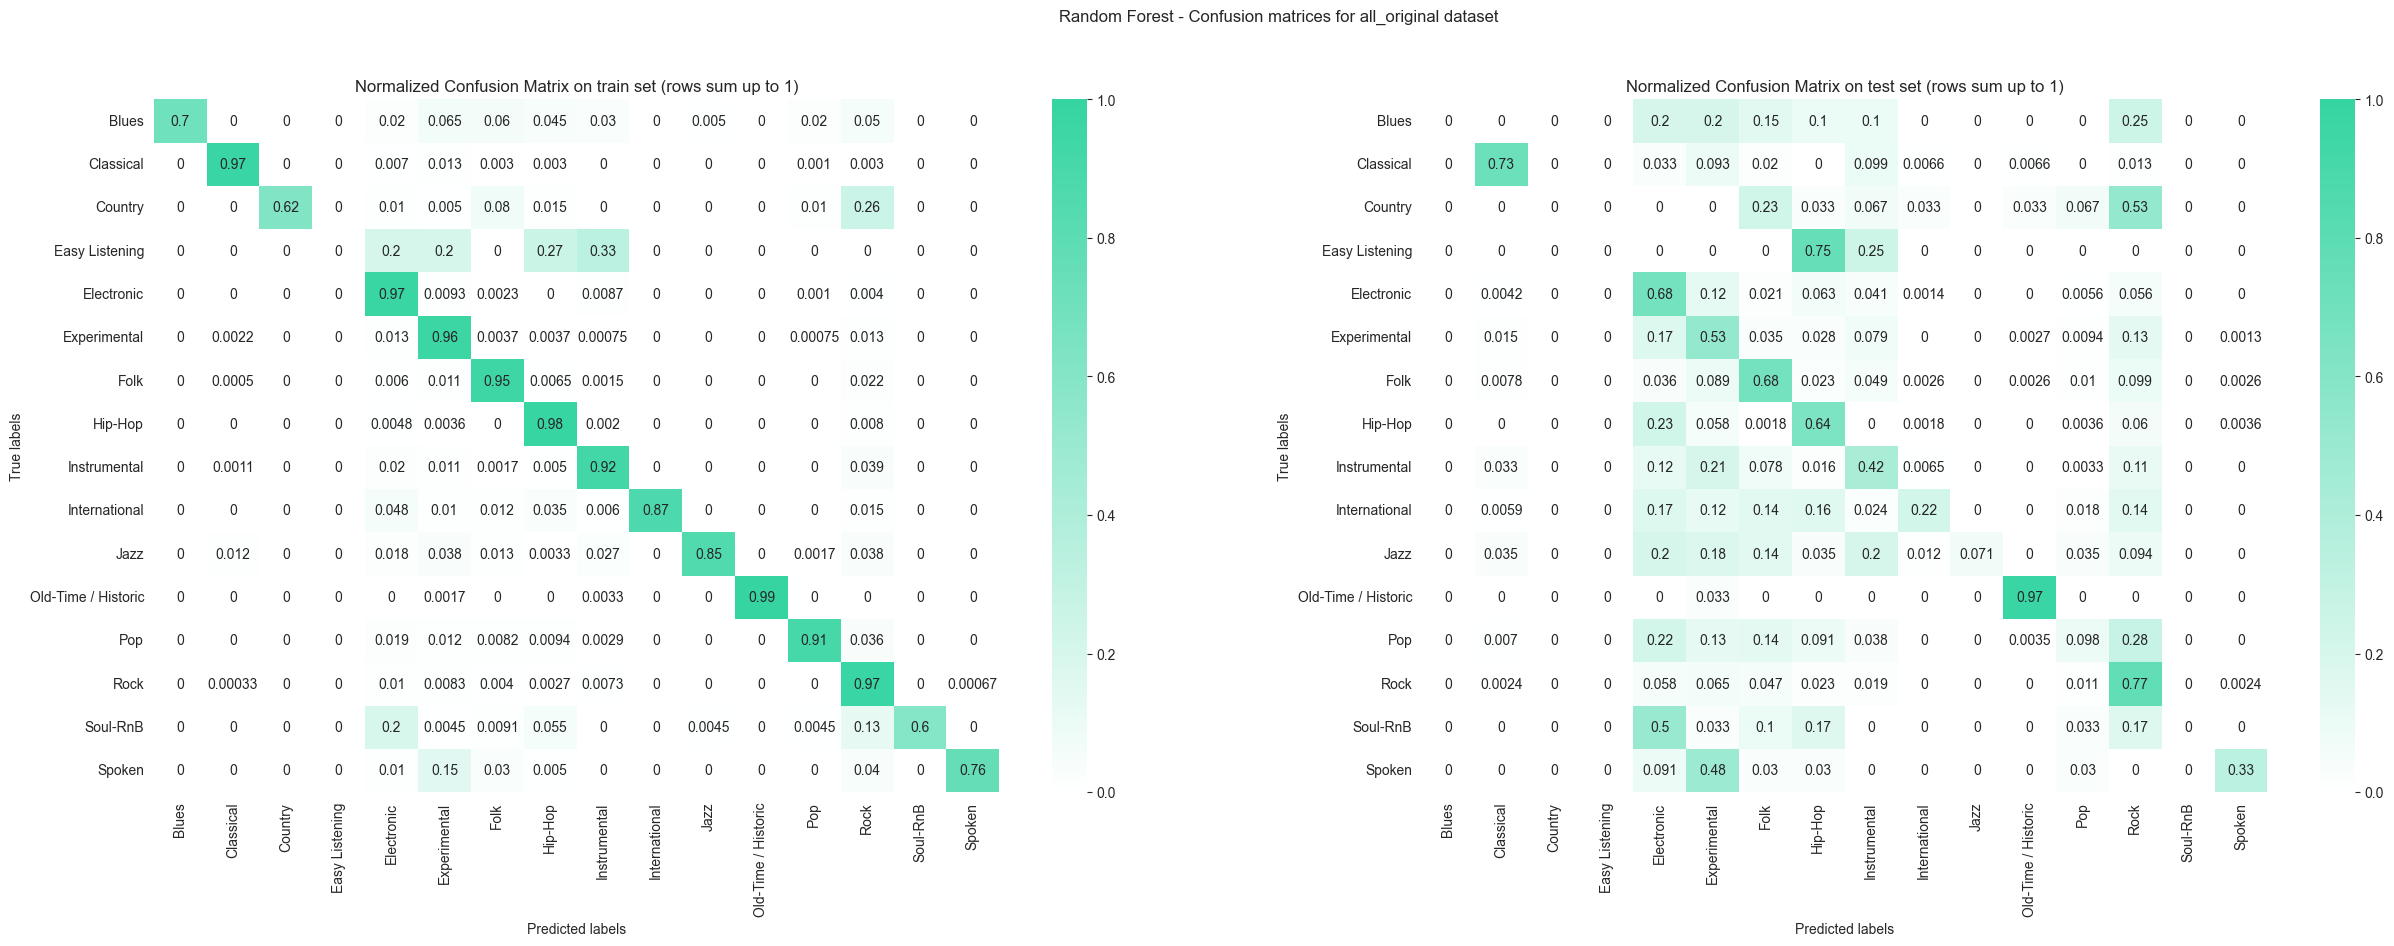

In [19]:
fig, axis = plt.subplots(1, 2, figsize=(30, 9))
rf_final_classifier.get_clf_evaluation().plot_confusion_matrix(ax=axis[0], on_set='train')
rf_final_classifier.get_clf_evaluation().plot_confusion_matrix(ax=axis[1], on_set='test')
fig.suptitle('Random Forest - Confusion matrices for all_original dataset')
plt.show()

We notice that the model performs very well on the train set, and not so well on the test set. From the following plots, we can conclude the following:
- Easy Listening tracks are not recognized by the model even on the train set (likely due to the small nuber of tracks that belong in this genre)
- When a model classifies a track as Jazz, does it with high precision (is certain that the track belongs to the Jazz genre), but fails to recognize most .of the tracks belonging in this category.
- None of the tracks we classified as Soul-RnB on the test set
- Old-Time / Historic tracks seem to be the most discriminative

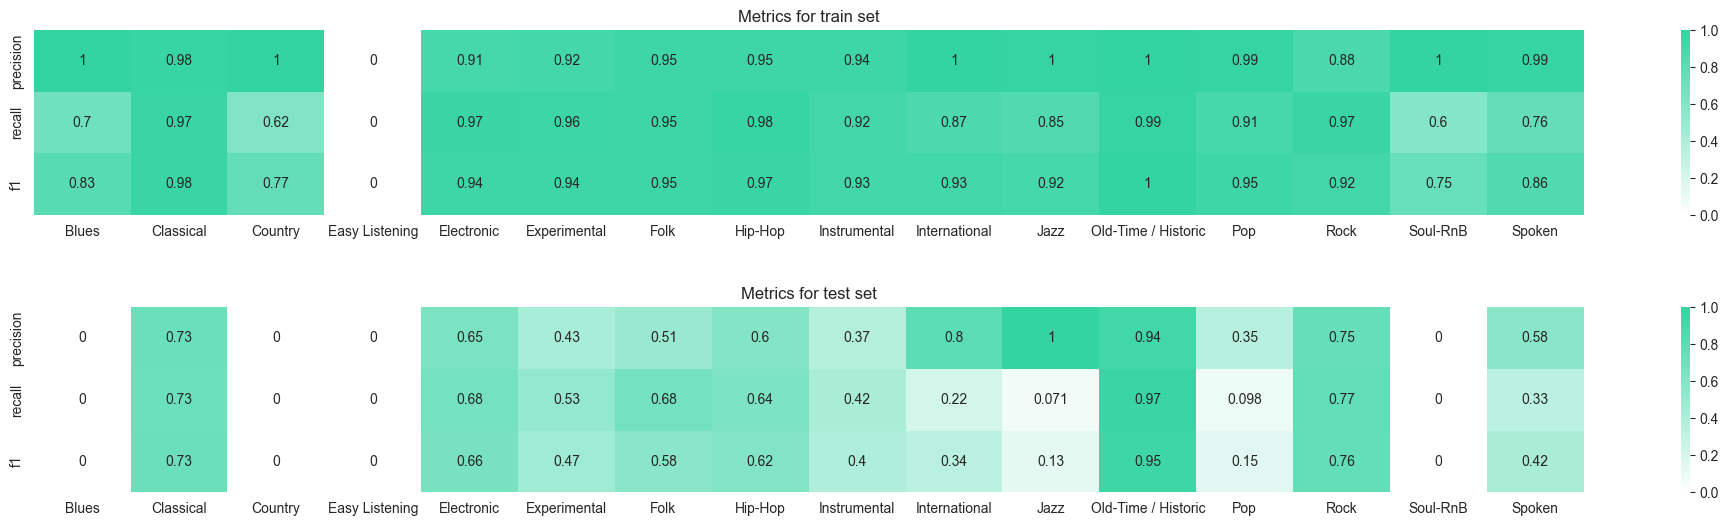

In [20]:
_, ax = plt.subplots(2, 1, figsize=(25, 6))
rf_final_classifier.get_clf_evaluation().plot_metrics_per_class(ax=ax[0], on_set='train')
rf_final_classifier.get_clf_evaluation().plot_metrics_per_class(ax=ax[1], on_set='test')
plt.subplots_adjust(hspace=0.5)
plt.show()

The following plot represents the feature importances, and we notice that most important feature (when building the trees), i.e. features that reduce the most uncertainty in the classification process are the spectral features.

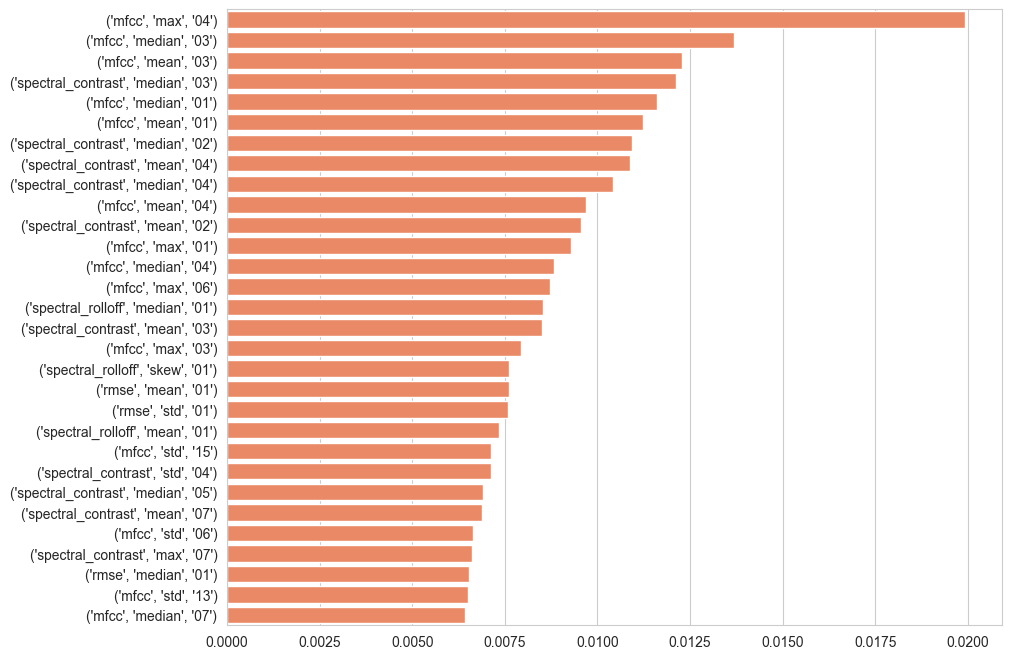

In [21]:
_, ax = plt.subplots(1, 1, figsize=(10, 8))
rf_final_classifier.get_clf_evaluation().plot_feature_importances(ax=ax, num_features=30)
plt.show()

Random forests may not be ideal for the task at hand since they only consider one feature at a time, making axis-aligned splits. This approach is unsuitable since the features being analyzed are highly interconnected. Namely, The MFCC features (and others) are interacting features that can distinguish between classes together, but not necessarily in isolation.
In order to overcome this limitation, a more appropriate model would need to be able to examine multiple features simultaneously (such as mean, median, standard deviation of the MFCCs).

# 2. XGBoost

## 2.1 Training

In [22]:
label_encoder = LabelEncoder()
datasets_wrapper.encode_labels(encoder=label_encoder)

In [23]:
xgb_classifiers = [classification_utils.ClassifierFactory.create_instance(
    dataset=dataset, 
    classifier=XGBClassifier(
        max_depth=4,
        learning_rate=0.1,
        n_estimators=100,
        n_jobs=5,
        verbosity=0,
        random_state=23,
    ),
    tree_type_classifier=True
) for dataset in datasets]

In [24]:
xgb_cl_collection = classification_utils.ClassifiersCollection(xgb_classifiers)

In [25]:
xgb_cl_collection.fit_classifiers()

Fitting classifiers...


100%|██████████| 8/8 [21:21<00:00, 160.23s/it]

Done


## 2.2 Initial Results

In [26]:
xgb_evaluation_df = xgb_cl_collection.evaluate_classifiers()

In [27]:
xgb_evaluation_df[[dataset.name for dataset in datasets if 'original' in dataset.name]]

spectral_original                     all_original  \
                                 train       val      test        train   
accuracy                      0.756536  0.633709  0.632738     0.773781   
precision (weighted)          0.763307  0.613471  0.604928     0.781610   
recall (weighted)             0.756536  0.633709  0.632738     0.773781   
f1 (weighted)                 0.742925  0.605181  0.603084     0.761562   

                                         pca_original                      \
                           val      test        train       val      test   
accuracy              0.644973  0.643751     0.734192  0.602003  0.600033   
precision (weighted)  0.640927  0.625195     0.748849  0.574297  0.571266   
recall (weighted)     0.644973  0.643751     0.734192  0.602003  0.600033   
f1 (weighted)         0.619089  0.614731     0.716731  0.567230  0.565380   

                     umap_original                      
                             train       val      test  
accuracy                  0.599852  0.550688  0.544135  
precision (weighted)      0.615238  0.530592  0.513144  
recall (weighted)         0.599852  0.550688  0.544135  
f1 (weighted)             0.575270  0.520508  0.514843

In [28]:
xgb_evaluation_df[[dataset.name for dataset in datasets if 'modified' in dataset.name]]

spectral_modified                     all_modified  \
                                 train       val      test        train   
accuracy                      0.776528  0.625782  0.606207     0.796611   
precision (weighted)          0.777732  0.638354  0.622663     0.797922   
recall (weighted)             0.776528  0.625782  0.606207     0.796611   
f1 (weighted)                 0.773931  0.626351  0.606854     0.794507   

                                         pca_modified                      \
                           val      test        train       val      test   
accuracy              0.627451  0.613716     0.758473  0.574468  0.582513   
precision (weighted)  0.634807  0.629149     0.768153  0.577896  0.582162   
recall (weighted)     0.627451  0.613716     0.758473  0.574468  0.582513   
f1 (weighted)         0.626971  0.613255     0.755468  0.567522  0.573410   

                     umap_modified                      
                             train       val      test  
accuracy                  0.588974  0.511055  0.504589  
precision (weighted)      0.603928  0.528587  0.523292  
recall (weighted)         0.588974  0.511055  0.504589  
f1 (weighted)             0.578102  0.509310  0.502831

Even though the metrics are the best on the all_modified dataset, the feature importances plot indicates that still the most discriminative features are the spectral features. Hence we will fine tune on the spectral_modified dataset (we chose the modified version because it addresses the class imbalance)

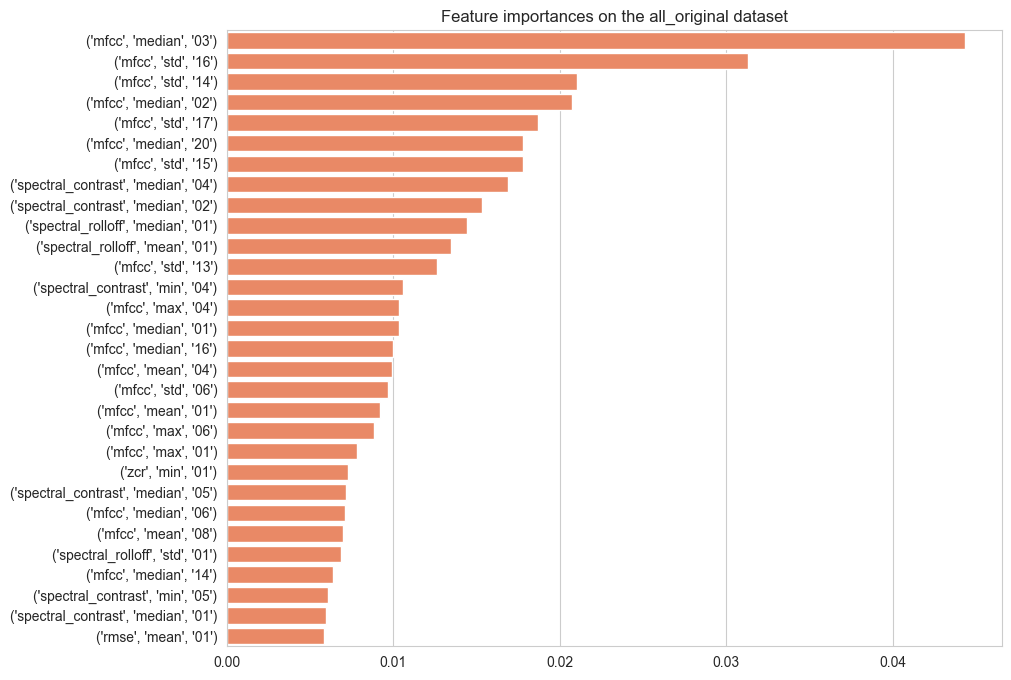

In [29]:
_, ax = plt.subplots(1, 1, figsize=(10, 8))
xgb_cl_collection.get_classifier('all_original').get_clf_evaluation().plot_feature_importances(ax=ax, num_features=30)
plt.title('Feature importances on the all_original dataset')
plt.show()

# Hyperparameter tuning

In [30]:
rf_final_classifier = classification_utils.ClassifierFactory.create_instance(
    dataset=rf_dataset,
    classifier=grid_search.best_estimator_,
    tree_type_classifier=True
)

In [31]:
xgb_spectral_modified = datasets_wrapper.get_dataset('spectral_modified')

xgb_classifier = XGBClassifier(
    max_depth=4,
    learning_rate=0.05,
    n_estimators=500,
    n_jobs=-1,
    verbosity=0,
    random_state=23,
    early_stopping_rounds=5
)

xgb_classifier.fit(
    xgb_spectral_modified.train.X,
    xgb_spectral_modified.train.y,
    eval_set=[(xgb_spectral_modified.val.X, xgb_spectral_modified.val.y)],
    verbose=False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=5,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [32]:
xgb_final_classifier = classification_utils.ClassifierFactory.create_instance(
    dataset=xgb_spectral_modified,
    classifier=xgb_classifier,
    tree_type_classifier=True,
    encoder=label_encoder
)

Inverse transform on the labels

In [33]:
datasets_wrapper.reverse_encode_labels()

In [34]:
xgb_final_classifier.get_clf_evaluation().get_scores()

,train,val,test
accuracy,0.911654,0.637881,0.630736
precision (weighted),0.911917,0.652413,0.645903
recall (weighted),0.911654,0.637881,0.630736
f1 (weighted),0.911377,0.639110,0.631218


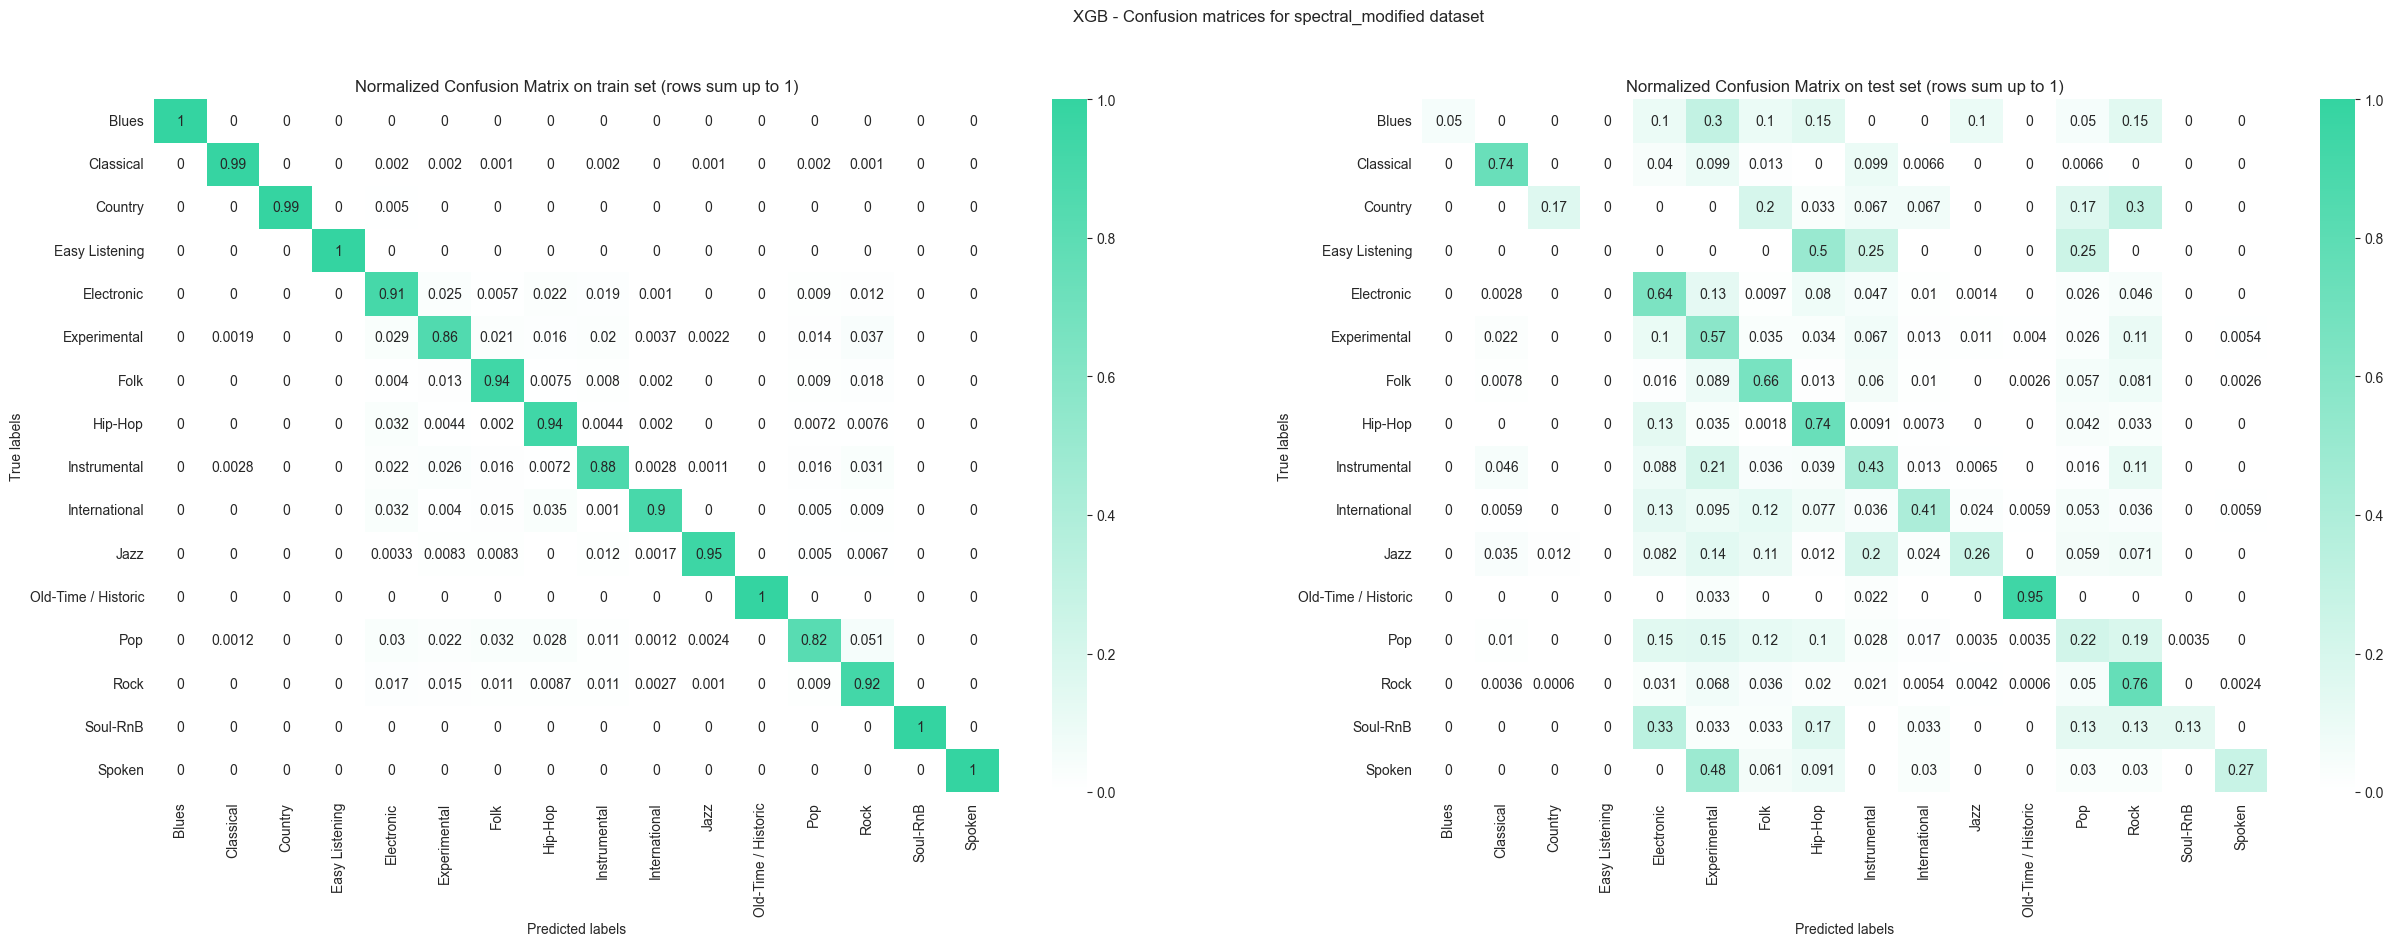

In [35]:
fig, axis = plt.subplots(1, 2, figsize=(30, 9))
xgb_final_classifier.get_clf_evaluation().plot_confusion_matrix(ax=axis[0], on_set='train')
xgb_final_classifier.get_clf_evaluation().plot_confusion_matrix(ax=axis[1], on_set='test')
fig.suptitle('XGB - Confusion matrices for spectral_modified dataset')
plt.show()

Similarly to the random forest, this classifier also overfits to the training set, but fails to generalize well on the test set. Again, none of the Easy Listening tracks are classified as such on the test set, and the classifier seems to perform well in recongizing and correctly classifying Old-Time / Historic as well as Rock songs. Other genres which the classifier correctly predicts are Country, Blues and Soul-RnB, but considering the small recall for these classes, it is probably the case that not many instances were classified as any of these genres.

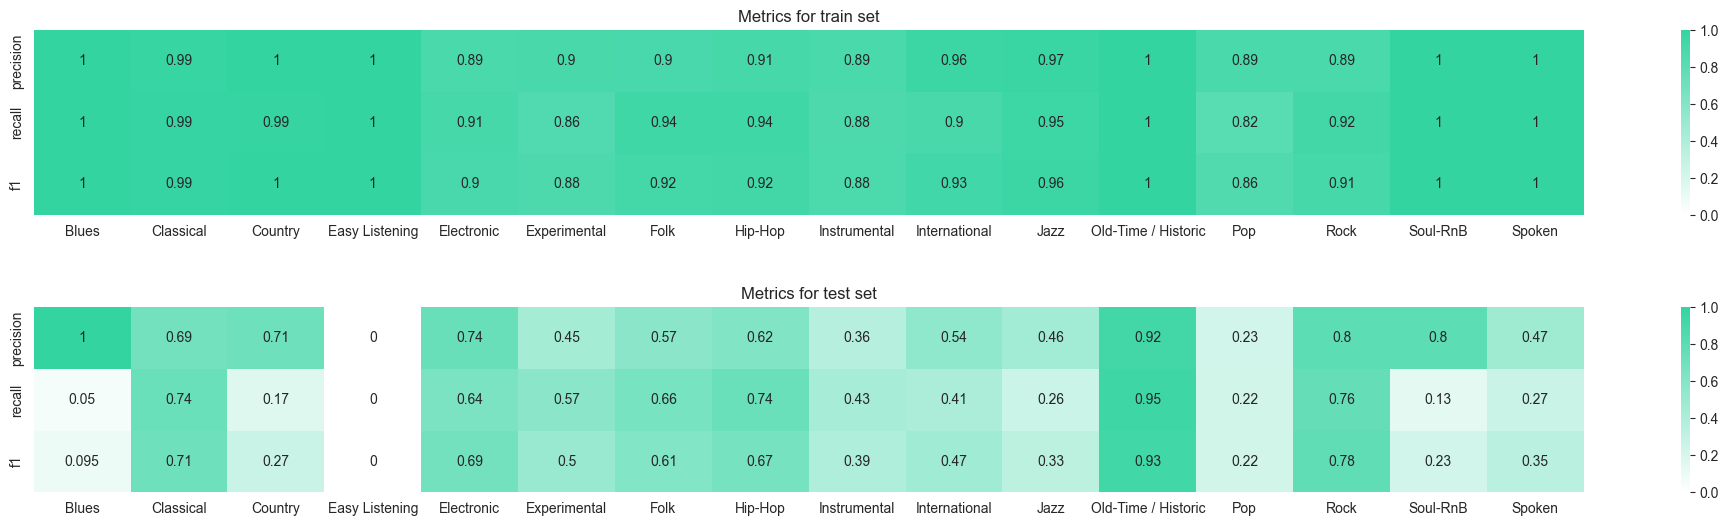

In [36]:
_, ax = plt.subplots(2, 1, figsize=(25, 6))
xgb_final_classifier.get_clf_evaluation().plot_metrics_per_class(ax=ax[0], on_set='train')
xgb_final_classifier.get_clf_evaluation().plot_metrics_per_class(ax=ax[1], on_set='test')
plt.subplots_adjust(hspace=0.5)
plt.show()


Similarly to the random forest, the most discriminative features for genre classification seem to be the spectral features (spectral contrast and MFCC).

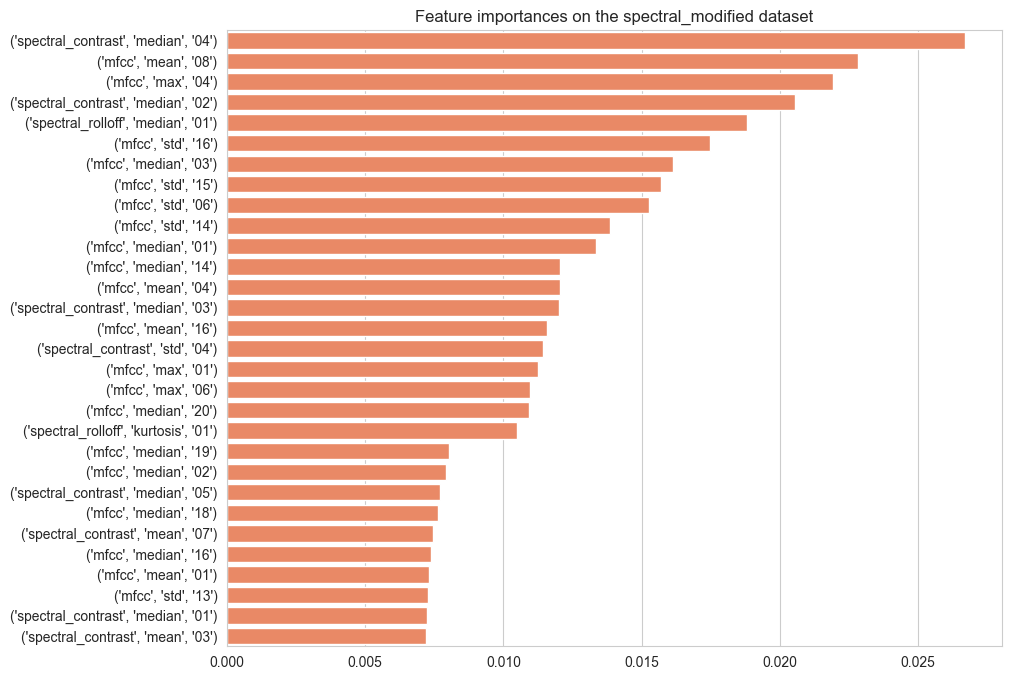

In [37]:
_, ax = plt.subplots(1, 1, figsize=(10, 8))
xgb_final_classifier.get_clf_evaluation().plot_feature_importances(ax=ax, num_features=30)
plt.title('Feature importances on the spectral_modified dataset')
plt.show()